In [1]:
pip install yfinance

In [2]:
pip install --upgrade yfinance

     -------------------------------------- 108.7/108.7 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.38
    Uninstalling yfinance-0.2.38:
      Successfully uninstalled yfinance-0.2.38
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas_datareader.data as web
import datetime

# Definir o período de tempo
start = datetime.datetime(2000, 1, 2)
end = datetime.datetime(2022, 1, 1)

# Baixar os dados do IBOVESPA
try:
    ibov_data = web.DataReader('^BVSP.SA', 'yahoo', start, end)
    print("Dados baixados com sucesso!")
except Exception as e:
    print(f"Erro ao baixar os dados: {e}")

Erro ao baixar os dados: 'NoneType' object has no attribute 'group'


[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst (Max Lag = 20):	0.5176
Hurst (Max Lag = 50):	0.5285
Hurst (Max Lag = 100):	0.4903
Hurst (Max Lag = 500):	0.3639


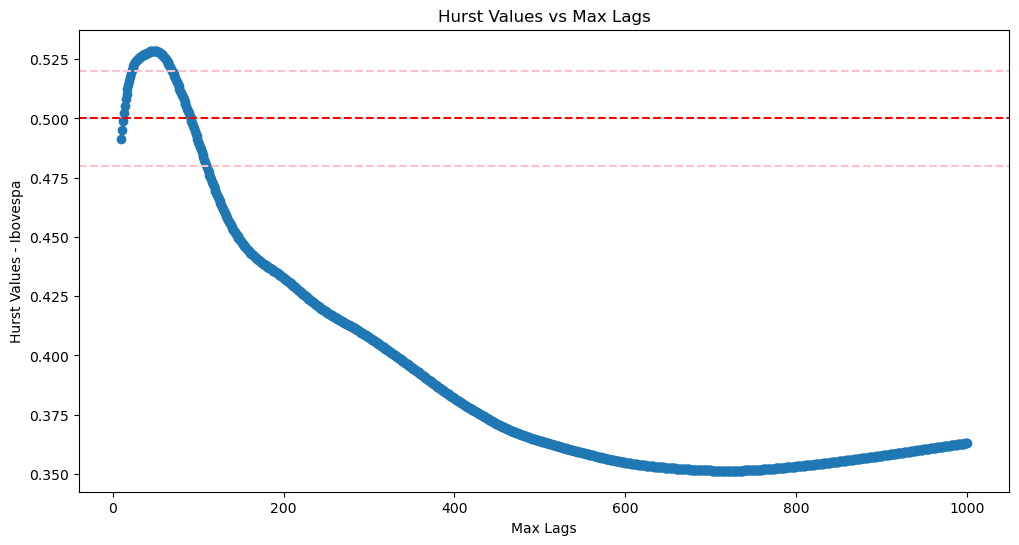

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixar os dados do IBOVESPA
ibov_data = yf.download('^BVSP', start='2000-01-02', end='2024-12-31')

# Verificar se os dados foram baixados corretamente
if ibov_data.empty:
    print("Erro: Nenhum dado foi baixado.")
else:
    # Criar o DataFrame
    df = pd.DataFrame(index=ibov_data.index)
    df['Fechamento'] = ibov_data['Close']

    # Função para calcular o expoente de Hurst
    def hurst(price, min_lag=2, max_lag=100):
        lags = np.arange(min_lag, max_lag + 1)
        sigmas = []
        
        for tau in lags:
            if tau >= len(price):
                continue
            diff = np.subtract(price[tau:], price[:-tau])
            if len(diff) == 0:
                continue
            sigma = np.std(diff)
            if np.isnan(sigma) or np.isinf(sigma):
                continue
            sigmas.append(sigma)
        
        if len(sigmas) < 2:
            raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
        
        lags = lags[:len(sigmas)]
        H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
        return H, c, lags, sigmas

    # Extrair os preços de fechamento
    series = df["Fechamento"].dropna().values

    # Calcular o expoente de Hurst
    try:
        H, c, lags, sigmas = hurst(series, 2, 200)
        print(f"Hurst IBOV:\t{H:.4f}")
        
        print(f"Hurst (Max Lag = 20):\t{hurst(series, 2, 20)[0]:.4f}")
        print(f"Hurst (Max Lag = 50):\t{hurst(series, 2, 50)[0]:.4f}")
        print(f"Hurst (Max Lag = 100):\t{hurst(series, 2, 100)[0]:.4f}")
        print(f"Hurst (Max Lag = 500):\t{hurst(series, 2, 500)[0]:.4f}")
        
        # Gerar um gráfico dos valores de Hurst
        max_lags = np.arange(10, 1000 + 1)
        all_hursts = [hurst(series, 2, max_lag)[0] for max_lag in max_lags]
        
        plt.figure(figsize=(12, 6))
        plt.plot(max_lags, all_hursts, marker='o')
        plt.axhline(y=0.52, color='pink', linestyle='--')
        plt.axhline(y=0.50, color='r', linestyle='--')
        plt.axhline(y=0.48, color='pink', linestyle='--')
        plt.xlabel('Max Lags')
        plt.ylabel('Hurst Values - Ibovespa')
        plt.title('Hurst Values vs Max Lags')
        plt.show()
    except Exception as e:
        print(f"Erro: {e}")

[*********************100%***********************]  1 of 1 completed


Expoente de Hurst (H): 0.4328


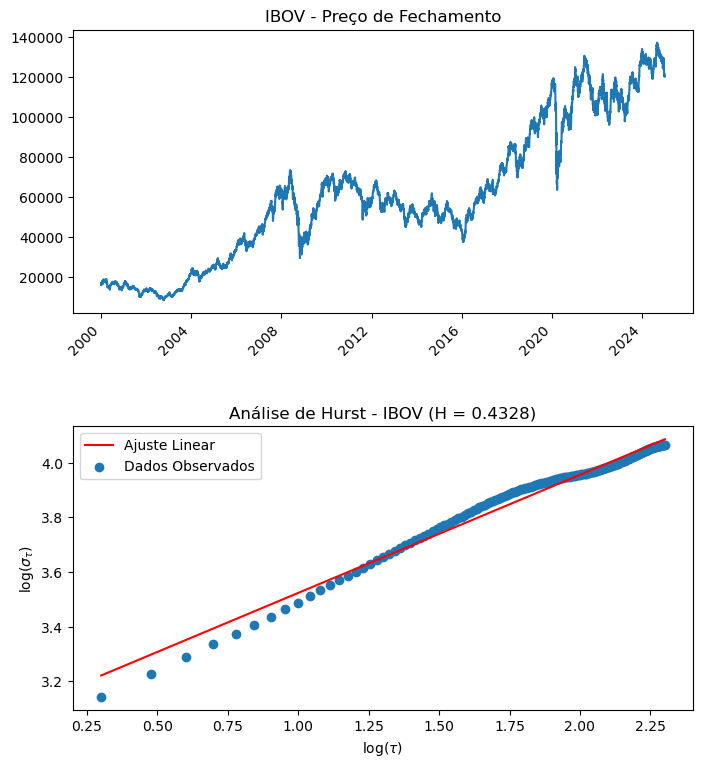

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixar os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=ibov_data.index)
df['Close'] = ibov_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplicar a função Hurst nos dados do Ibovespa
series = df['Close'].dropna().values

try:
    H, c, lags, sigmas = hurst(series, 2, 200)
    print(f"Expoente de Hurst (H): {H:.4f}")
except Exception as e:
    print(f"Erro ao calcular o expoente de Hurst: {e}")

# Criar os gráficos
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Gráfico dos dados de fechamento do IBOV
df['Close'].plot(ax=ax[0], rot=45, xlabel="")
ax[0].set_title("IBOV - Preço de Fechamento")

# Gráfico da análise de Hurst
ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color="red", label="Ajuste Linear")
ax[1].scatter(np.log10(lags), np.log10(sigmas), label="Dados Observados")
ax[1].set_title(f"Análise de Hurst - IBOV (H = {H:.4f})")
ax[1].set_xlabel(r"log($\tau$)")
ax[1].set_ylabel(r"log($\sigma_\tau$)")
ax[1].legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst (Max Lag = 20):	0.5176
Hurst (Max Lag = 50):	0.5285
Hurst (Max Lag = 100):	0.4903
Hurst (Max Lag = 500):	0.3639


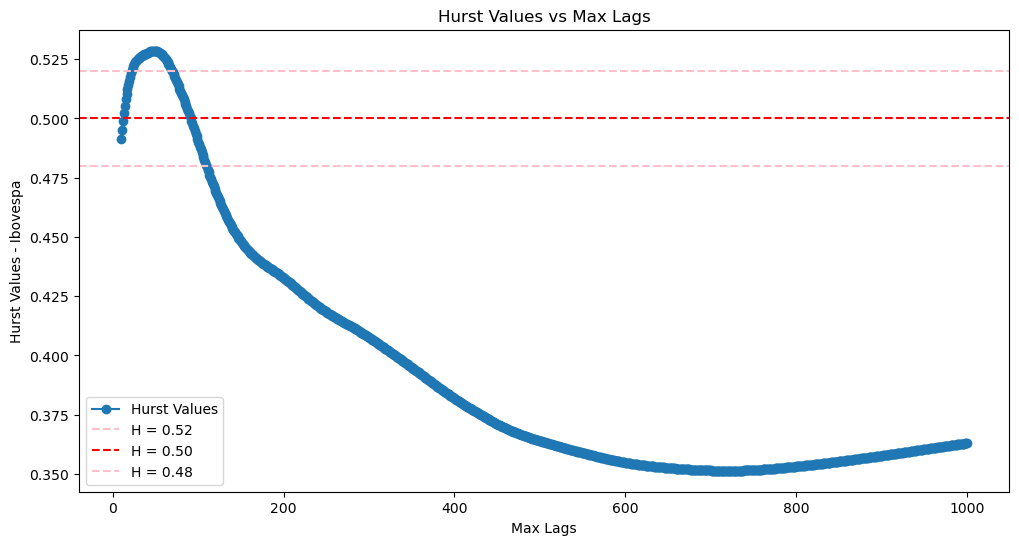

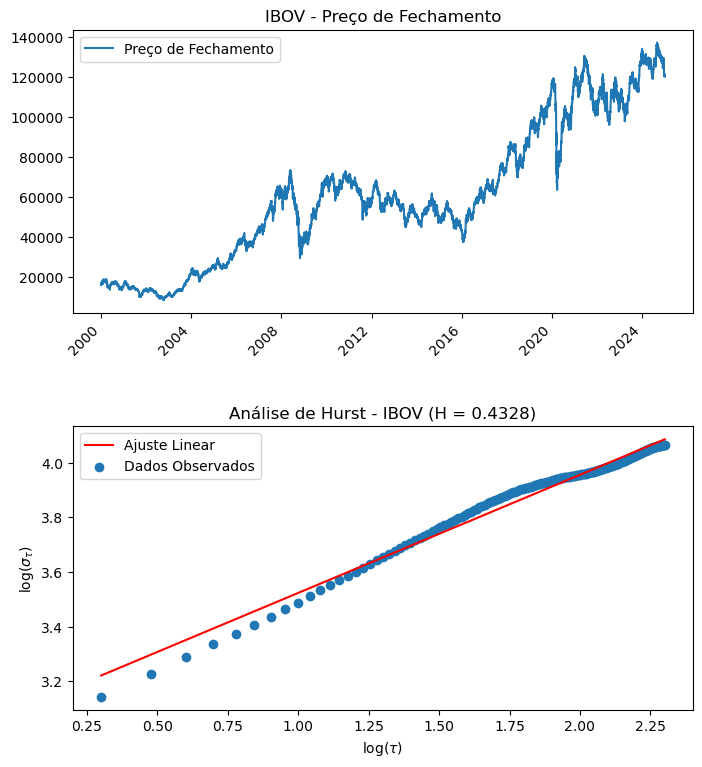

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=ibov_data.index)
df['Fechamento'] = ibov_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplica a função Hurst nos dados do Ibovespa
series = df['Fechamento'].dropna().values

try:
    # Calcula o expoente de Hurst para diferentes lags máximos
    H, c, lags, sigmas = hurst(series, 2, 200)
    print(f"Hurst IBOV:\t{H:.4f}")
    print(f"Hurst (Max Lag = 20):\t{hurst(series, 2, 20)[0]:.4f}")
    print(f"Hurst (Max Lag = 50):\t{hurst(series, 2, 50)[0]:.4f}")
    print(f"Hurst (Max Lag = 100):\t{hurst(series, 2, 100)[0]:.4f}")
    print(f"Hurst (Max Lag = 500):\t{hurst(series, 2, 500)[0]:.4f}")
    
    # Plota o gráfico Hurst vs. Max Lags
    max_lags = np.arange(10, 1000 + 1)
    all_hursts = [hurst(series, 2, max_lag)[0] for max_lag in max_lags]

    plt.figure(figsize=(12, 6))
    plt.plot(max_lags, all_hursts, marker='o', label="Hurst Values")
    plt.axhline(y=0.52, color='pink', linestyle='--', label="H = 0.52")
    plt.axhline(y=0.50, color='r', linestyle='--', label="H = 0.50")
    plt.axhline(y=0.48, color='pink', linestyle='--', label="H = 0.48")
    plt.xlabel('Max Lags')
    plt.ylabel('Hurst Values - Ibovespa')
    plt.title('Hurst Values vs Max Lags')
    plt.legend()
    plt.show()

    # Plota os gráficos do IBOV e análise de Hurst
    fig, ax = plt.subplots(2, 1, figsize=(8, 10))

    # Gráfico dos dados de fechamento do IBOV
    df['Fechamento'].plot(ax=ax[0], rot=45, xlabel="", label="Preço de Fechamento")
    ax[0].set_title("IBOV - Preço de Fechamento")
    ax[0].legend()

    # Gráfico da análise de Hurst
    ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color="red", label="Ajuste Linear")
    ax[1].scatter(np.log10(lags), np.log10(sigmas), label="Dados Observados")
    ax[1].set_title(f"Análise de Hurst - IBOV (H = {H:.4f})")
    ax[1].set_xlabel(r"log($\tau$)")
    ax[1].set_ylabel(r"log($\sigma_\tau$)")
    ax[1].legend()

    plt.subplots_adjust(hspace=0.4)
    plt.show()

except Exception as e:
    print(f"Erro: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst Dow Jones:	0.4405


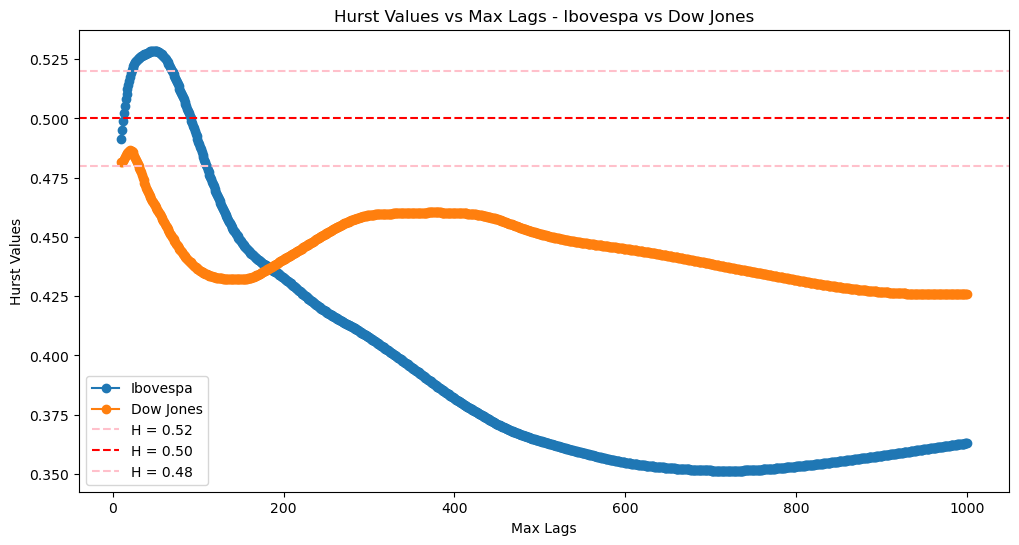

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df_ibov = pd.DataFrame(index=ibov_data.index)
df_ibov['Fechamento'] = ibov_data['Close']

# Baixa os dados do Dow Jones usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2022-01-01')
df_dow = pd.DataFrame(index=dow_data.index)
df_dow['Fechamento'] = dow_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Análise para o Ibovespa
series_ibov = df_ibov["Fechamento"].dropna().values
H_ibov, _, _, _ = hurst(series_ibov, 2, 200)
print(f"Hurst IBOV:\t{H_ibov:.4f}")

# Análise para o Dow Jones
series_dow = df_dow["Fechamento"].dropna().values
H_dow, _, _, _ = hurst(series_dow, 2, 200)
print(f"Hurst Dow Jones:\t{H_dow:.4f}")

# Gráfico de Hurst para ambos os índices
max_lags = np.arange(10, 1000 + 1)
all_hursts_ibov = [hurst(series_ibov, 2, max_lag)[0] for max_lag in max_lags]
all_hursts_dow = [hurst(series_dow, 2, max_lag)[0] for max_lag in max_lags]

plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts_ibov, label='Ibovespa', marker='o')
plt.plot(max_lags, all_hursts_dow, label='Dow Jones', marker='o')
plt.axhline(y=0.52, color='pink', linestyle='--', label="H = 0.52")
plt.axhline(y=0.50, color='r', linestyle='--', label="H = 0.50")
plt.axhline(y=0.48, color='pink', linestyle='--', label="H = 0.48")
plt.xlabel('Max Lags')
plt.ylabel('Hurst Values')
plt.title('Hurst Values vs Max Lags - Ibovespa vs Dow Jones')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst Dow Jones:	0.4301


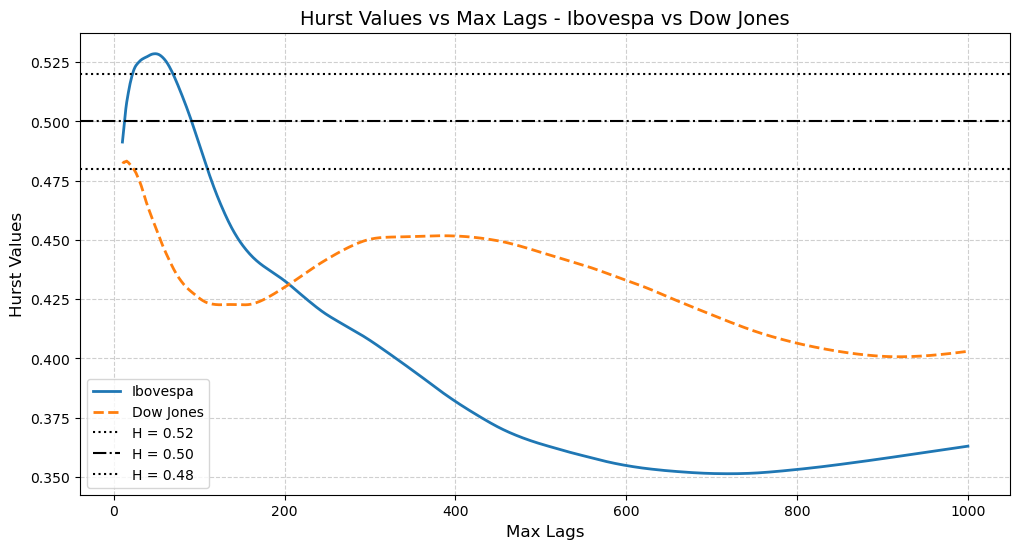

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df_ibov = pd.DataFrame(index=ibov_data.index)
df_ibov['Fechamento'] = ibov_data['Close']

# Baixa os dados do Dow Jones usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2024-12-31')
df_dow = pd.DataFrame(index=dow_data.index)
df_dow['Fechamento'] = dow_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Análise para o Ibovespa
series_ibov = df_ibov["Fechamento"].dropna().values
H_ibov, _, _, _ = hurst(series_ibov, 2, 200)
print(f"Hurst IBOV:\t{H_ibov:.4f}")

# Análise para o Dow Jones
series_dow = df_dow["Fechamento"].dropna().values
H_dow, _, _, _ = hurst(series_dow, 2, 200)
print(f"Hurst Dow Jones:\t{H_dow:.4f}")

# Gráfico de Hurst para ambos os índices
max_lags = np.arange(10, 1000 + 1)
all_hursts_ibov = [hurst(series_ibov, 2, max_lag)[0] for max_lag in max_lags]
all_hursts_dow = [hurst(series_dow, 2, max_lag)[0] for max_lag in max_lags]

plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts_ibov, label='Ibovespa', linestyle='-', linewidth=2)  # Linha sólida para o Ibovespa
plt.plot(max_lags, all_hursts_dow, label='Dow Jones', linestyle='--', linewidth=2)  # Linha tracejada para o Dow Jones
plt.axhline(y=0.52, color='black', linestyle=':', linewidth=1.5, label="H = 0.52")  # Linha pontilhada para referência
plt.axhline(y=0.50, color='black', linestyle='-.', linewidth=1.5, label="H = 0.50")  # Linha traço-ponto para referência
plt.axhline(y=0.48, color='black', linestyle=':', linewidth=1.5, label="H = 0.48")  # Linha pontilhada para referência
plt.xlabel('Max Lags', fontsize=12)
plt.ylabel('Hurst Values', fontsize=12)
plt.title('Hurst Values vs Max Lags - Ibovespa vs Dow Jones', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Adiciona uma grade para melhorar a leitura
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst Dow Jones:	0.4301


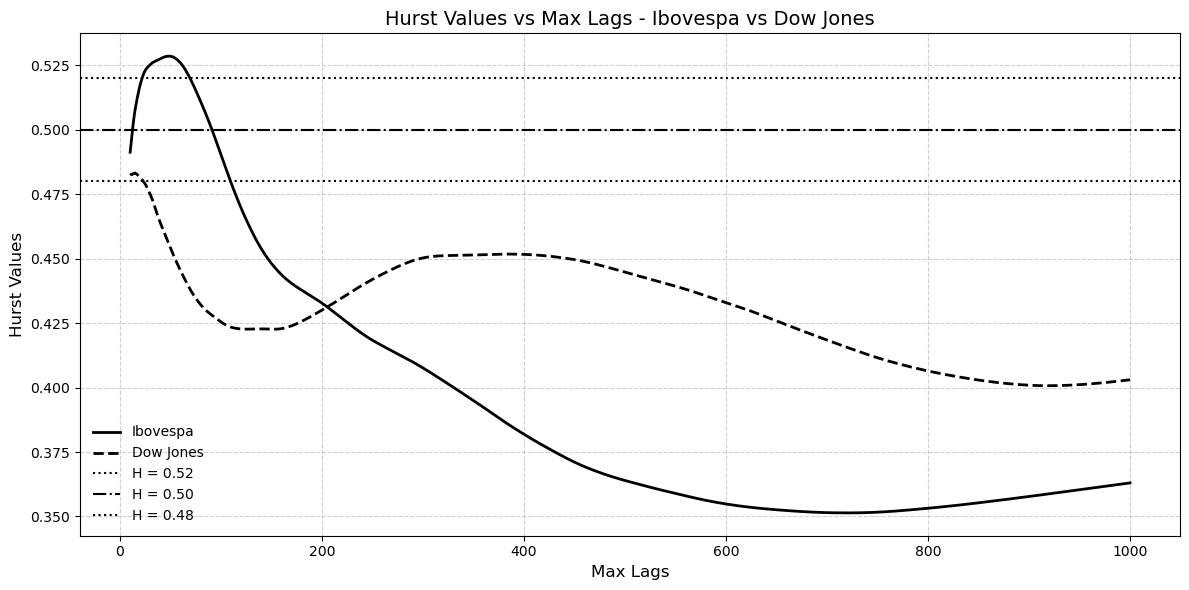

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df_ibov = pd.DataFrame(index=ibov_data.index)
df_ibov['Fechamento'] = ibov_data['Close']

# Baixa os dados do Dow Jones usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2024-12-31')
df_dow = pd.DataFrame(index=dow_data.index)
df_dow['Fechamento'] = dow_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Análise para o Ibovespa
series_ibov = df_ibov["Fechamento"].dropna().values
H_ibov, _, _, _ = hurst(series_ibov, 2, 200)
print(f"Hurst IBOV:\t{H_ibov:.4f}")

# Análise para o Dow Jones
series_dow = df_dow["Fechamento"].dropna().values
H_dow, _, _, _ = hurst(series_dow, 2, 200)
print(f"Hurst Dow Jones:\t{H_dow:.4f}")

# Gráfico de Hurst para ambos os índices
max_lags = np.arange(10, 1000 + 1)
all_hursts_ibov = [hurst(series_ibov, 2, max_lag)[0] for max_lag in max_lags]
all_hursts_dow = [hurst(series_dow, 2, max_lag)[0] for max_lag in max_lags]

# Configurações do gráfico
plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts_ibov, label='Ibovespa', linestyle='-', linewidth=2, color='black')  # Linha sólida para o Ibovespa
plt.plot(max_lags, all_hursts_dow, label='Dow Jones', linestyle='--', linewidth=2, color='black')  # Linha tracejada para o Dow Jones
plt.axhline(y=0.52, color='black', linestyle=':', linewidth=1.5, label="H = 0.52")  # Linha pontilhada para referência
plt.axhline(y=0.50, color='black', linestyle='-.', linewidth=1.5, label="H = 0.50")  # Linha traço-ponto para referência
plt.axhline(y=0.48, color='black', linestyle=':', linewidth=1.5, label="H = 0.48")  # Linha pontilhada para referência
plt.xlabel('Max Lags', fontsize=12)
plt.ylabel('Hurst Values', fontsize=12)
plt.title('Hurst Values vs Max Lags - Ibovespa vs Dow Jones', fontsize=14)
plt.legend(fontsize=10, frameon=False)  # Remove a borda da legenda
plt.grid(True, linestyle='--', alpha=0.6)  # Adiciona uma grade para melhorar a leitura
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Hurst IBOV:	0.4328
Hurst Dow Jones:	0.4301
Hurst Nikkei 225:	0.4721


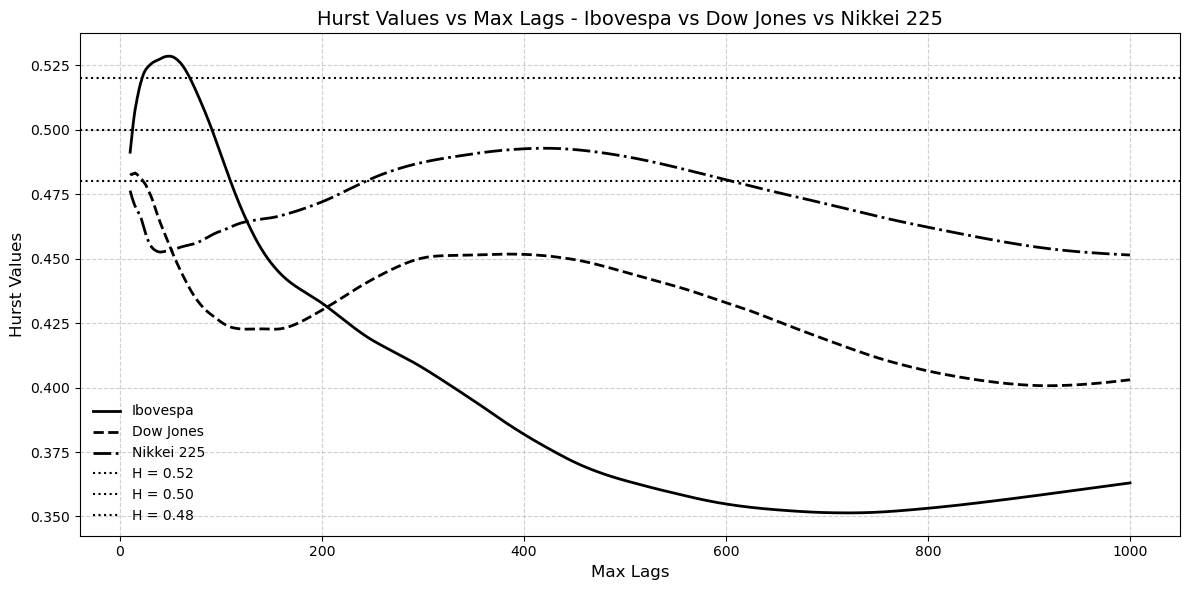

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Ibovespa usando yfinance
ibov_data = yf.download('^BVSP', start='2000-01-01', end='2024-12-31')
df_ibov = pd.DataFrame(index=ibov_data.index)
df_ibov['Fechamento'] = ibov_data['Close']

# Baixa os dados do Dow Jones usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2024-12-31')
df_dow = pd.DataFrame(index=dow_data.index)
df_dow['Fechamento'] = dow_data['Close']

# Baixa os dados do Nikkei 225 usando yfinance
nikkei_data = yf.download('^N225', start='2000-01-01', end='2024-12-31')
df_nikkei = pd.DataFrame(index=nikkei_data.index)
df_nikkei['Fechamento'] = nikkei_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Análise para o Ibovespa
series_ibov = df_ibov["Fechamento"].dropna().values
H_ibov, _, _, _ = hurst(series_ibov, 2, 200)
print(f"Hurst IBOV:\t{H_ibov:.4f}")

# Análise para o Dow Jones
series_dow = df_dow["Fechamento"].dropna().values
H_dow, _, _, _ = hurst(series_dow, 2, 200)
print(f"Hurst Dow Jones:\t{H_dow:.4f}")

# Análise para o Nikkei 225
series_nikkei = df_nikkei["Fechamento"].dropna().values
H_nikkei, _, _, _ = hurst(series_nikkei, 2, 200)
print(f"Hurst Nikkei 225:\t{H_nikkei:.4f}")

# Gráfico de Hurst para os três índices
max_lags = np.arange(10, 1000 + 1)
all_hursts_ibov = [hurst(series_ibov, 2, max_lag)[0] for max_lag in max_lags]
all_hursts_dow = [hurst(series_dow, 2, max_lag)[0] for max_lag in max_lags]
all_hursts_nikkei = [hurst(series_nikkei, 2, max_lag)[0] for max_lag in max_lags]

# Configurações do gráfico
plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts_ibov, label='Ibovespa', linestyle='-', linewidth=2, color='black')  # Linha sólida para o Ibovespa
plt.plot(max_lags, all_hursts_dow, label='Dow Jones', linestyle='--', linewidth=2, color='black')  # Linha tracejada para o Dow Jones
plt.plot(max_lags, all_hursts_nikkei, label='Nikkei 225', linestyle='-.', linewidth=2, color='black')  # Linha traço-ponto para o Nikkei
plt.axhline(y=0.52, color='black', linestyle=':', linewidth=1.5, label="H = 0.52")  # Linha pontilhada para referência
plt.axhline(y=0.50, color='black', linestyle=':', linewidth=1.5, label="H = 0.50")  # Linha pontilhada para referência
plt.axhline(y=0.48, color='black', linestyle=':', linewidth=1.5, label="H = 0.48")  # Linha pontilhada para referência
plt.xlabel('Max Lags', fontsize=12)
plt.ylabel('Hurst Values', fontsize=12)
plt.title('Hurst Values vs Max Lags - Ibovespa vs Dow Jones vs Nikkei 225', fontsize=14)
plt.legend(fontsize=10, frameon=False)  # Remove a borda da legenda
plt.grid(True, linestyle='--', alpha=0.6)  # Adiciona uma grade para melhorar a leitura
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

[*********************100%***********************]  1 of 1 completed


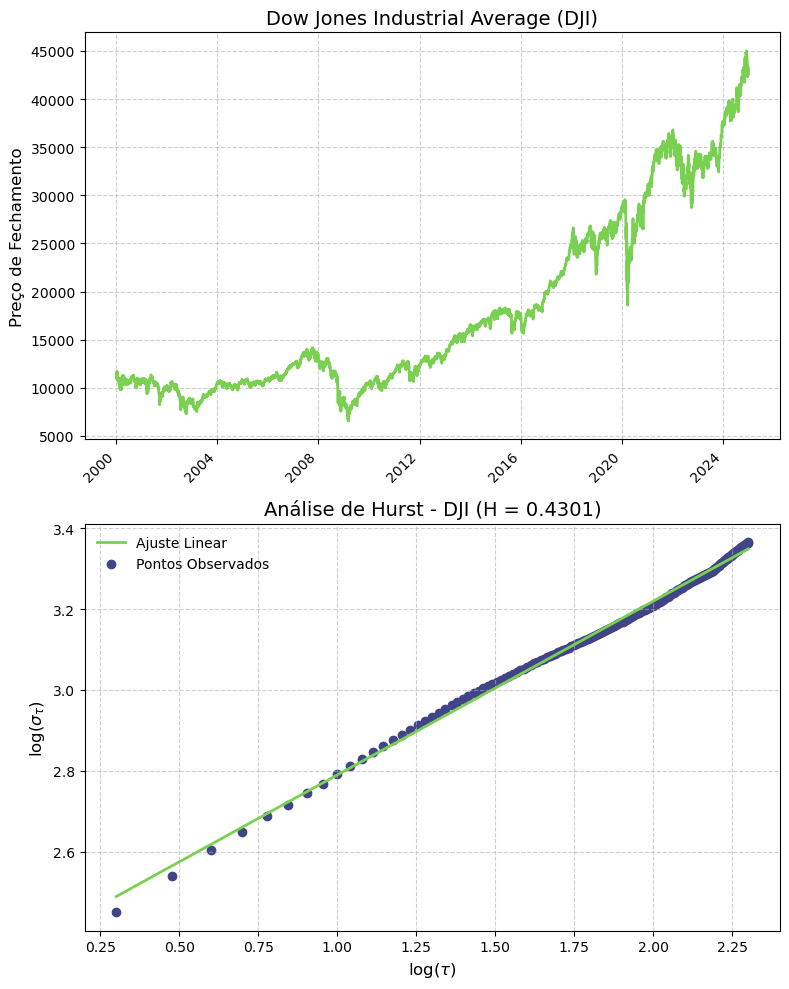

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.cm import viridis

# Baixar os dados do Dow Jones (DJI) usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=dow_data.index)
df['Close'] = dow_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplicar a função Hurst nos dados do DJI
series = df['Close'].dropna().values
H, c, lags, sigmas = hurst(series, 2, 200)

# Criar o gráfico com esquema de cores Viridis
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Gráfico dos dados de fechamento do DJI
df['Close'].plot(ax=ax[0], rot=45, xlabel="", color=viridis(0.8), linewidth=2)
ax[0].set_title("Dow Jones Industrial Average (DJI)", fontsize=14)
ax[0].set_ylabel("Preço de Fechamento", fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico da análise de Hurst
ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color=viridis(0.8), linewidth=2, label="Ajuste Linear")
ax[1].scatter(np.log10(lags), np.log10(sigmas), color=viridis(0.2), label='Pontos Observados')
ax[1].set_title(f"Análise de Hurst - DJI (H = {H:.4f})", fontsize=14)
ax[1].set_xlabel(r"log($\tau$)", fontsize=12)
ax[1].set_ylabel(r"log($\sigma_\tau$)", fontsize=12)
ax[1].legend(fontsize=10, frameon=False)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Ajustar o layout
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


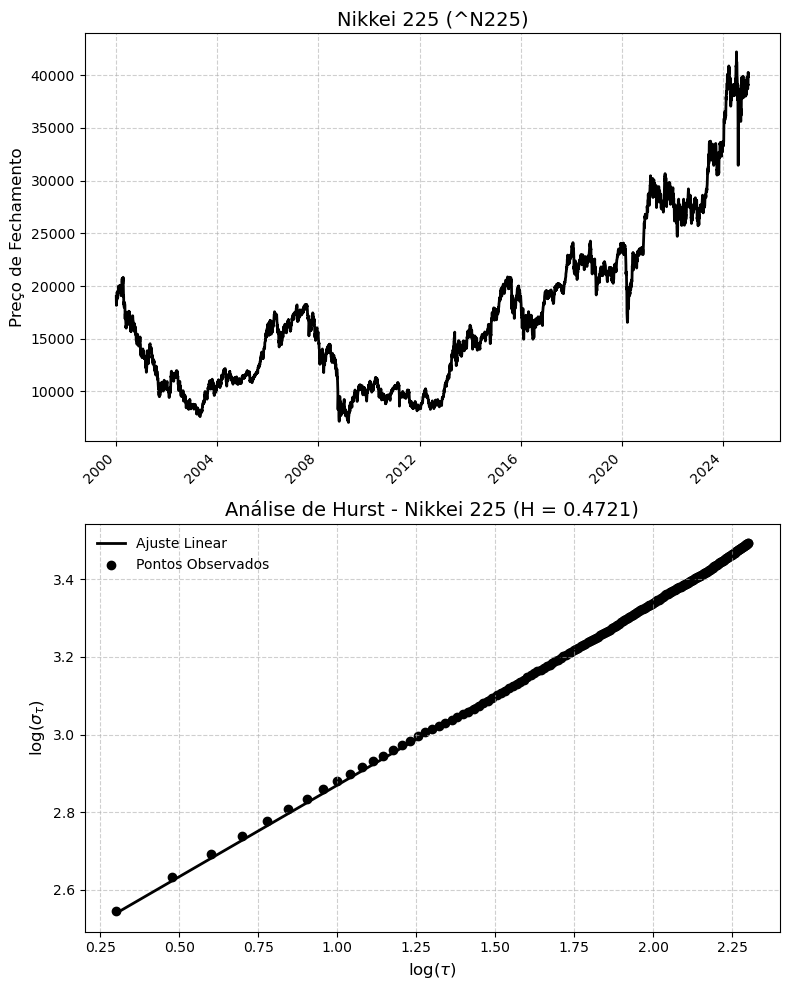

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixar os dados do Nikkei 225 usando yfinance
nikkei_data = yf.download('^N225', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=nikkei_data.index)
df['Close'] = nikkei_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplicar a função Hurst nos dados do Nikkei 225
series = df['Close'].dropna().values
H, c, lags, sigmas = hurst(series, 2, 200)

# Criar o gráfico em preto e branco
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Gráfico dos dados de fechamento do Nikkei 225
df['Close'].plot(ax=ax[0], rot=45, xlabel="", color='black', linewidth=2)
ax[0].set_title("Nikkei 225 (^N225)", fontsize=14)
ax[0].set_ylabel("Preço de Fechamento", fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico da análise de Hurst
ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color='black', linestyle='-', linewidth=2, label="Ajuste Linear")
ax[1].scatter(np.log10(lags), np.log10(sigmas), color='black', marker='o', label='Pontos Observados')
ax[1].set_title(f"Análise de Hurst - Nikkei 225 (H = {H:.4f})", fontsize=14)
ax[1].set_xlabel(r"log($\tau$)", fontsize=12)
ax[1].set_ylabel(r"log($\sigma_\tau$)", fontsize=12)
ax[1].legend(fontsize=10, frameon=False)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Ajustar o layout
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Hurst DOW:	0.4301
Hurst (Max Lag = 20):	0.4814
Hurst (Max Lag = 50):	0.4541
Hurst (Max Lag = 100):	0.4254
Hurst (Max Lag = 500):	0.4448


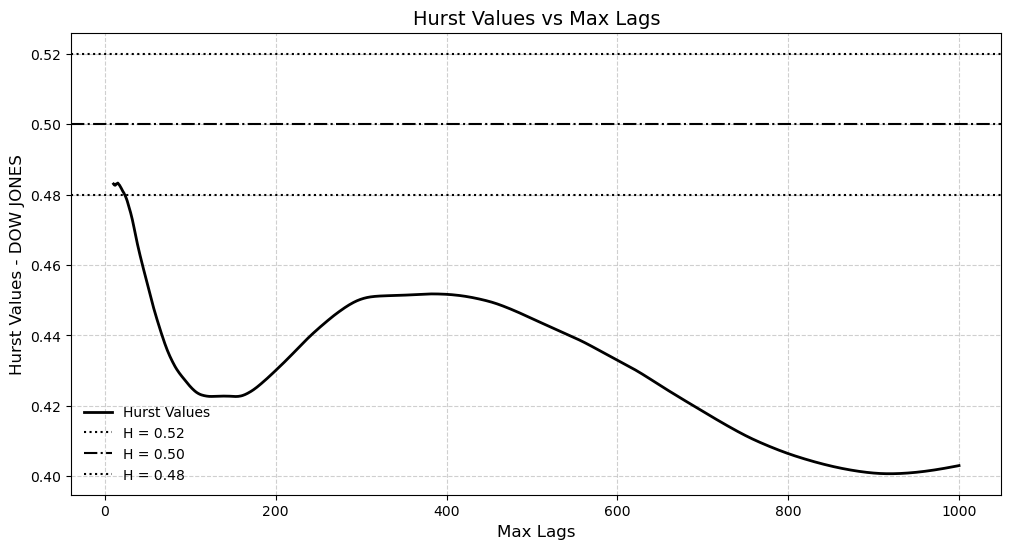

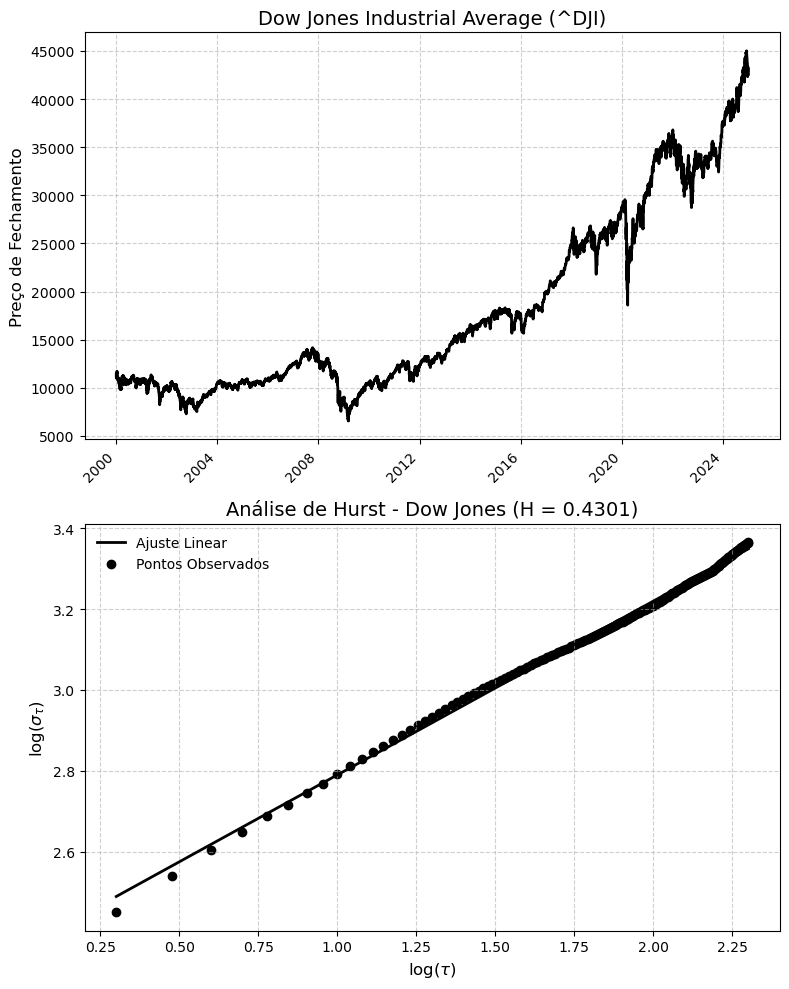

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Dow Jones usando yfinance
dow_data = yf.download('^DJI', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=dow_data.index)
df['Fechamento'] = dow_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplica a função Hurst nos dados do Dow Jones
series = df['Fechamento'].dropna().values
H, c, lags, sigmas = hurst(series, 2, 200)

# Imprime os resultados da análise de Hurst
print(f"Hurst DOW:\t{H:.4f}")
print(f"Hurst (Max Lag = 20):\t{hurst(series, 2, 20)[0]:.4f}")
print(f"Hurst (Max Lag = 50):\t{hurst(series, 2, 50)[0]:.4f}")
print(f"Hurst (Max Lag = 100):\t{hurst(series, 2, 100)[0]:.4f}")
print(f"Hurst (Max Lag = 500):\t{hurst(series, 2, 500)[0]:.4f}")

# Plota o gráfico Hurst vs. Max Lags
max_lags = np.arange(10, 1000 + 1)
all_hursts = [hurst(series, 2, max_lag)[0] for max_lag in max_lags]

plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts, linestyle='-', linewidth=2, color='black', label='Hurst Values')
plt.axhline(y=0.52, color='black', linestyle=':', linewidth=1.5, label="H = 0.52")
plt.axhline(y=0.50, color='black', linestyle='-.', linewidth=1.5, label="H = 0.50")
plt.axhline(y=0.48, color='black', linestyle=':', linewidth=1.5, label="H = 0.48")
plt.xlabel('Max Lags', fontsize=12)
plt.ylabel('Hurst Values - DOW JONES', fontsize=12)
plt.title('Hurst Values vs Max Lags', fontsize=14)
plt.legend(fontsize=10, frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plota os gráficos do Dow e análise de Hurst
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Gráfico dos dados de fechamento do Dow
df['Fechamento'].plot(ax=ax[0], rot=45, xlabel="", color='black', linewidth=2)
ax[0].set_title("Dow Jones Industrial Average (^DJI)", fontsize=14)
ax[0].set_ylabel("Preço de Fechamento", fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico da análise de Hurst
ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color='black', linestyle='-', linewidth=2, label="Ajuste Linear")
ax[1].scatter(np.log10(lags), np.log10(sigmas), color='black', marker='o', label='Pontos Observados')
ax[1].set_title(f"Análise de Hurst - Dow Jones (H = {H:.4f})", fontsize=14)
ax[1].set_xlabel(r"log($\tau$)", fontsize=12)
ax[1].set_ylabel(r"log($\sigma_\tau$)", fontsize=12)
ax[1].legend(fontsize=10, frameon=False)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Ajustar o layout
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Hurst NIKKEI:	0.4721
Hurst (Max Lag = 20):	0.4665
Hurst (Max Lag = 50):	0.4532
Hurst (Max Lag = 100):	0.4608
Hurst (Max Lag = 500):	0.4897


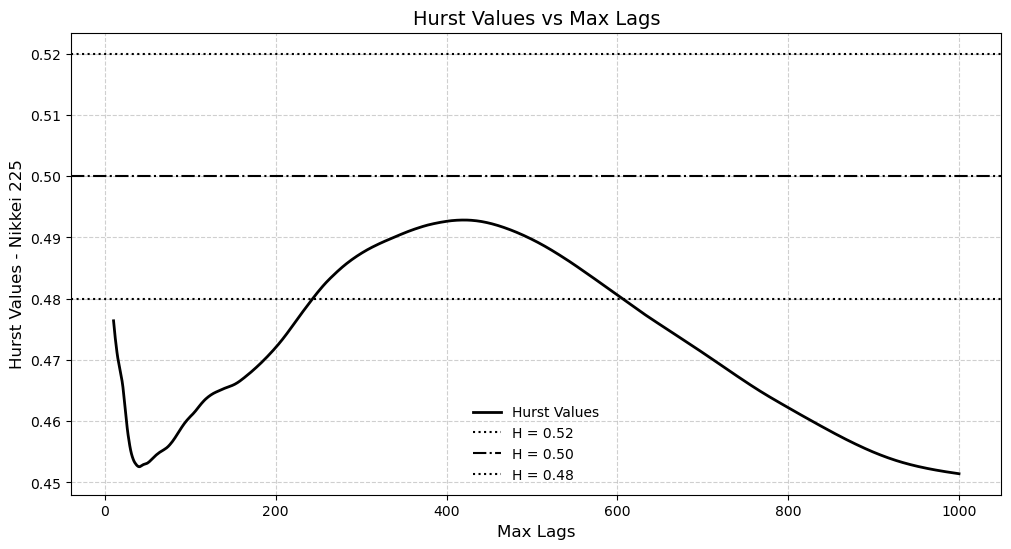

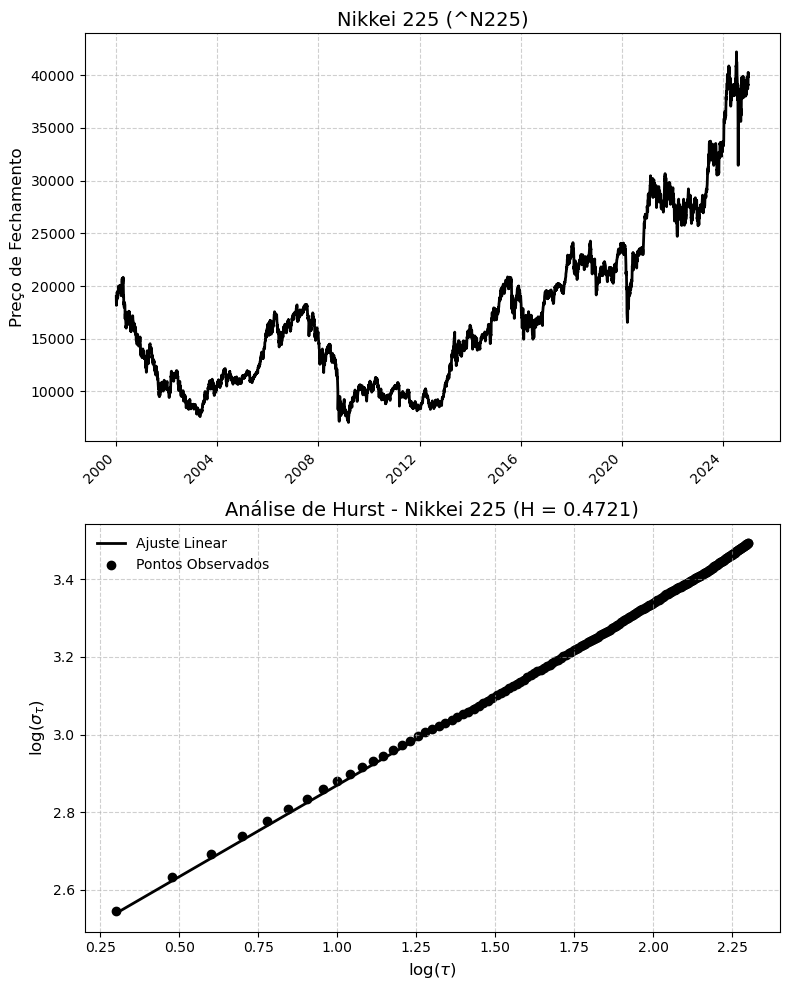

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Baixa os dados do Nikkei 225 usando yfinance
nikkei_data = yf.download('^N225', start='2000-01-01', end='2024-12-31')
df = pd.DataFrame(index=nikkei_data.index)
df['Fechamento'] = nikkei_data['Close']

# Função Hurst
def hurst(price, min_lag=2, max_lag=100):
    lags = np.arange(min_lag, max_lag + 1)
    sigmas = []
    
    for tau in lags:
        if tau >= len(price):
            continue  # Ignorar lags maiores que o tamanho da série
        diff = np.subtract(price[tau:], price[:-tau])  # Corrigido: np.subtract
        if len(diff) == 0:
            continue  # Ignorar se a diferença for vazia
        sigma = np.std(diff)
        if np.isnan(sigma) or np.isinf(sigma):
            continue  # Ignorar valores inválidos
        sigmas.append(sigma)
    
    if len(sigmas) < 2:
        raise ValueError("Não há dados suficientes para calcular o expoente de Hurst.")
    
    lags = lags[:len(sigmas)]  # Ajustar o tamanho dos lags
    H, c = np.polyfit(np.log10(lags), np.log10(sigmas), 1)
    return H, c, lags, sigmas

# Aplica a função Hurst nos dados do Nikkei 225
series = df['Fechamento'].dropna().values
H, c, lags, sigmas = hurst(series, 2, 200)

# Imprime os resultados da análise de Hurst
print(f"Hurst NIKKEI:\t{H:.4f}")
print(f"Hurst (Max Lag = 20):\t{hurst(series, 2, 20)[0]:.4f}")
print(f"Hurst (Max Lag = 50):\t{hurst(series, 2, 50)[0]:.4f}")
print(f"Hurst (Max Lag = 100):\t{hurst(series, 2, 100)[0]:.4f}")
print(f"Hurst (Max Lag = 500):\t{hurst(series, 2, 500)[0]:.4f}")

# Plota o gráfico Hurst vs. Max Lags
max_lags = np.arange(10, 1000 + 1)
all_hursts = [hurst(series, 2, max_lag)[0] for max_lag in max_lags]

plt.figure(figsize=(12, 6))
plt.plot(max_lags, all_hursts, linestyle='-', linewidth=2, color='black', label='Hurst Values')
plt.axhline(y=0.52, color='black', linestyle=':', linewidth=1.5, label="H = 0.52")
plt.axhline(y=0.50, color='black', linestyle='-.', linewidth=1.5, label="H = 0.50")
plt.axhline(y=0.48, color='black', linestyle=':', linewidth=1.5, label="H = 0.48")
plt.xlabel('Max Lags', fontsize=12)
plt.ylabel('Hurst Values - Nikkei 225', fontsize=12)
plt.title('Hurst Values vs Max Lags', fontsize=14)
plt.legend(fontsize=10, frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plota os gráficos do Nikkei e análise de Hurst
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Gráfico dos dados de fechamento do Nikkei
df['Fechamento'].plot(ax=ax[0], rot=45, xlabel="", color='black', linewidth=2)
ax[0].set_title("Nikkei 225 (^N225)", fontsize=14)
ax[0].set_ylabel("Preço de Fechamento", fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico da análise de Hurst
ax[1].plot(np.log10(lags), H * np.log10(lags) + c, color='black', linestyle='-', linewidth=2, label="Ajuste Linear")
ax[1].scatter(np.log10(lags), np.log10(sigmas), color='black', marker='o', label='Pontos Observados')
ax[1].set_title(f"Análise de Hurst - Nikkei 225 (H = {H:.4f})", fontsize=14)
ax[1].set_xlabel(r"log($\tau$)", fontsize=12)
ax[1].set_ylabel(r"log($\sigma_\tau$)", fontsize=12)
ax[1].legend(fontsize=10, frameon=False)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Ajustar o layout
plt.tight_layout()
plt.show()